In [1]:
import nibabel as nb
import numpy as np
import mne
import matplotlib.pyplot as plt

In [2]:
# Read the image
img = nb.load('/scratch/mcesped/Results/hippunfold/old_run/hippunfold/sub-P060/anat/sub-P060_hemi-R_space-cropT1w_desc-subfields_atlas-histologyReference2023_dseg.nii.gz')
#nb.load('/project/ctb-akhanf/cfmm-bids/Khan/SNSX_7T_2021/correct7T.dev/gradcorrect_v0.0.3/sub-P060/anat/sub-P060_acq-MP2RAGEpostproc_run-01_T1w.nii.gz')

In [3]:
type(img)

nibabel.nifti1.Nifti1Image

In [4]:
data = img.get_fdata()

In [6]:
data.shape

(256, 256, 256)

In [7]:
inv_affine = np.linalg.inv(img.affine)

In [5]:
# Test 1 coordinate
coord = [30.462402292, 12.172049632400006, -40.1737889638]

In [8]:
# To voxels
vox = np.round((mne.transforms.apply_trans(inv_affine, coord))).astype(int)
vox

array([174, 161, 111])

## Unipolar

In [7]:
mask = np.zeros(data.shape)

In [8]:
mask[vox[0], vox[1], vox[2]] = 1

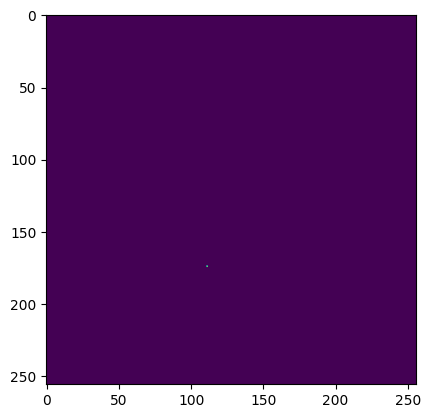

In [9]:
plt.imshow(mask[:, vox[1], :])

In [10]:
from skimage.morphology import dilation
from skimage.morphology import ball

footprint = ball(1)
dilated = dilation(mask, footprint)

In [91]:
dilated = mask.copy()
idx_in = int(np.floor(len(footprint)/2))
idx_end = int(np.ceil(len(footprint)/2))
dilated[vox[0]-idx_in:vox[0]+idx_end, vox[1]-idx_in:vox[1]+idx_end, vox[2]-idx_in:vox[2]+idx_end] = footprint

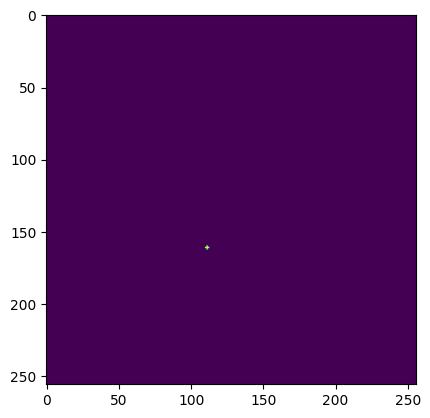

In [ ]:
plt.imshow(dilated[vox[0],:,:])

In [93]:
clipped_img = nb.Nifti1Image(dilated, img.affine, img.header)

In [94]:
nb.save(clipped_img, 'test.nii.gz')

In [96]:
img.header['pixdim']

array([1.        , 0.19687499, 0.19840176, 0.19568151, 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

# Test 2 points

In [9]:
point_A = [28.469, 12.165, -40.180]
point_B = [32.456, 12.179, -40.168]

In [10]:
# Convert to voxels
point_A = np.round((mne.transforms.apply_trans(inv_affine, point_A))).astype(int)
point_B = np.round((mne.transforms.apply_trans(inv_affine, point_B))).astype(int)

In [11]:
print(point_A, point_B)

[164 161 111] [184 161 111]


In [12]:
# https://www.geeksforgeeks.org/bresenhams-algorithm-for-3-d-line-drawing/
def create_line_mask(point1, point2, shape):
    # Create an empty mask with the specified shape
    mask = np.zeros(shape, dtype=bool)
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    # Set the first element to true
    mask[x1, y1, z1] = True
    # Get the directions of each axis
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    dz = abs(z2 - z1)
    if (x2 > x1):
        xs = 1
    else:
        xs = -1
    if (y2 > y1):
        ys = 1
    else:
        ys = -1
    if (z2 > z1):
        zs = 1
    else:
        zs = -1
 
    # Driving axis is X-axis
    if (dx >= dy and dx >= dz):       
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while (x1 != x2):
            x1 += xs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dx
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz
            mask[x1, y1, z1] = True
        mask[x1, y1, z1] = True
 
    # Driving axis is Y-axis"
    elif (dy >= dx and dy >= dz):      
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while (y1 != y2):
            y1 += ys
            if (p1 >= 0):
                x1 += xs
                p1 -= 2 * dy
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz
            mask[x1, y1, z1] = True
        mask[x1, y1, z1] = True
 
    # Driving axis is Z-axis"
    else:       
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while (z1 != z2):
            z1 += zs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dz
            if (p2 >= 0):
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx
            mask[x1, y1, z1] = True
        mask[x1, y1, z1] = True
    return mask

In [13]:
a = np.random.rand(10,3)
a[0,:].tolist()

[0.36211341938870356, 0.03811833518368857, 0.563022630231779]

In [15]:
test_mask = create_line_mask(point_A, point_B, data.shape)

In [16]:
print([array.tolist() for array in np.where(test_mask)])

[[164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184], [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161], [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]]


In [96]:
from skimage.morphology import dilation
from skimage.morphology import ball

footprint = ball(2)
dilated = dilation(test_mask, footprint)

In [104]:
dilated2 = dilated.copy()
footprint = ball(3)
idx_in = int(np.floor(len(footprint)/2))
idx_end = int(np.ceil(len(footprint)/2))
for point in [point_A, point_B]:
    dilated2[point[0]-idx_in:point[0]+idx_end, point[1]-idx_in:point[1]+idx_end, point[2]-idx_in:point[2]+idx_end] += footprint.astype(bool)

In [105]:
from scipy.ndimage import gaussian_filter
result = gaussian_filter(dilated2.astype(float), sigma=0.6)

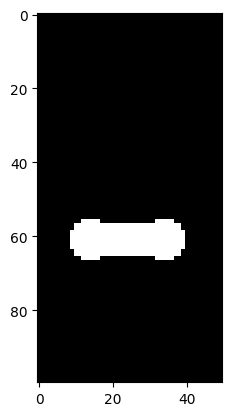

In [115]:
plt.imshow((result[150:200,vox[1],50:150]>0).transpose(), cmap='gray') # Adjusted the view to look like slicer

In [107]:
clipped_img = nb.Nifti1Image(result>0, img.affine, img.header)
nb.save(clipped_img, 'test_blur_mask.nii.gz')

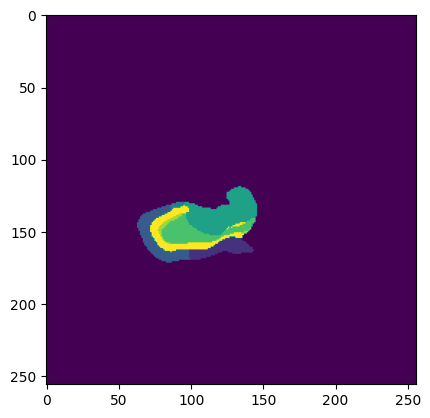

In [34]:
# Show labels
plt.imshow(data[::-1,vox[1],::-1].transpose())

(256, 256, 256)


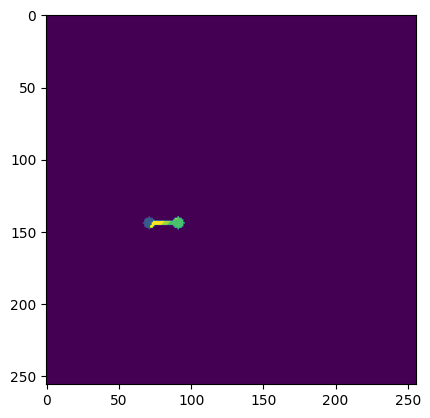

In [35]:
masked_labels = data * dilated2
print(masked_labels.shape)
plt.imshow(masked_labels[::-1,vox[1],::-1].transpose())

In [63]:
masked_img = nb.Nifti1Image(masked_labels, img.affine, img.header)
nb.save(masked_img, 'masked.nii.gz')

In [50]:
len(masked_labels[dilated])

67

In [73]:
data[dilated]

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       6., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 7., 6., 6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 2., 7., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.])

In [82]:
freq_labels = []
regions_chn = data[dilated]
for label in np.unique(regions_chn):
    freq_labels.append((label, np.round(len(regions_chn[regions_chn==label])/len(regions_chn), 2)))
    
freq_labels

[(2.0, 0.11), (5.0, 0.35), (6.0, 0.19), (7.0, 0.36)]

In [84]:
sorted(freq_labels, key=lambda x: x[1], reverse=True)[0][0]

7.0

In [40]:
data.shape

(256, 256, 256)

# Test multiple electrodes

In [19]:
import pandas as pd
import SimpleITK as sitk
from skimage.morphology import dilation
from skimage.morphology import ball

In [2]:
channels_tsv = '/scratch/mcesped/Results/seegprep/hipp_run/work/sub-068/ses-005/ieeg/sub-068_ses-005_task-full_rec-reref_run-01_reref_native_space.tsv'
df_channels = pd.read_csv(channels_tsv, sep='\t')
df_channels.head()

,type,group,label,x_init,x_end,y_init,y_end,z_init,z_end
0,SEEGA,LAIn,LAIn1-2,-33.948,-32.609,44.602,45.995,-0.933,1.646
1,SEEGA,LAIn,LAIn2-3,-32.609,-31.847,45.995,46.867,1.646,3.742
2,SEEGA,LAIn,LAIn3-4,-31.847,-30.644,46.867,48.118,3.742,6.166
3,SEEGA,LAIn,LAIn4-5,-30.644,-29.500,48.118,49.173,6.166,8.611
4,SEEGA,LAIn,LAIn5-6,-29.500,-28.387,49.173,50.579,8.611,11.046


In [3]:
labels_chns = df_channels['label'].to_list()

In [12]:
tfm_list = [('/scratch/mcesped/Results/seegprep/hipp_run/work/sub-068/anat/sub-068_tf.txt', False)]
elec_df = df_channels
df_cols = [
                "type",
                "group",
                "label",
                "x_init",
                "x_end",
                "y_init",
                "y_end",
                "z_init",
                "z_end",
            ]
df_cols = dict(zip(df_cols, df_cols))
parc = img

In [13]:
# Function to read matrix
def readRegMatrix(trsfPath):
    with open(trsfPath) as (f):
        return np.loadtxt(f.readlines())

In [14]:
# parc, elec_df, df_cols, tfm_list, label_map
# Load data of parcellations
data_parc = np.asarray(parc.dataobj)
# Coordinates in MRI RAS
mri_ras_mm_init = elec_df[
    [df_cols["x_init"], df_cols["y_init"], df_cols["z_init"]]
].values
mri_ras_mm_end = elec_df[
    [df_cols["x_end"], df_cols["y_end"], df_cols["z_end"]]
].values
# Get channel names to build json file
chn_names = elec_df[df_cols["label"]].values
# print(mri_ras_mm)
# Apply transforms
for tfm, inv_bool in tfm_list:
    if type(tfm) == str:
        if tfm.endswith("txt"):
            tfm = readRegMatrix(tfm)
            if inv_bool:
                tfm = np.linalg.inv(tfm)
            mri_ras_mm_init = mne.transforms.apply_trans(tfm, mri_ras_mm_init)
            mri_ras_mm_end = mne.transforms.apply_trans(tfm, mri_ras_mm_end)
        elif tfm.endswith("nii.gz"):
            # reads the transform and casts the output compaitble format
            transform_image = sitk.ReadImage(tfm)
            transform_image = sitk.Cast(transform_image, sitk.sitkVectorFloat64)
            # load it as a transform
            identity_transform = sitk.Transform(transform_image)
            # Convert points from RAS to LPS
            mri_mni_lps_init = mri_ras_mm_init * np.array([-1, -1, 1])
            mri_mni_lps_end = mri_ras_mm_end * np.array([-1, -1, 1])
            # Transform
            for point_id in range(mri_mni_lps_init.shape[0]):
                mri_mni_lps_init[point_id, :] = np.array(
                    identity_transform.TransformPoint(mri_mni_lps_init[point_id, :])
                )
                mri_mni_lps_end[point_id, :] = np.array(
                    identity_transform.TransformPoint(mri_mni_lps_end[point_id, :])
                )
            # Convert from LPS back to RAS
            mri_ras_mm_init = mri_mni_lps_init * np.array([-1, -1, 1])
            mri_ras_mm_end = mri_mni_lps_end * np.array([-1, -1, 1])

    else:
        if inv_bool:
            tfm = np.linalg.inv(tfm)
        mri_ras_mm_init = mne.transforms.apply_trans(tfm, mri_ras_mm_init)
        mri_ras_mm_end = mne.transforms.apply_trans(tfm, mri_ras_mm_end)
# To voxels
inv_affine = np.linalg.inv(parc.affine)
# here's where the interpolation should be performed!!
vox_init = np.round(
    (mne.transforms.apply_trans(inv_affine, mri_ras_mm_init))
).astype(int)
vox_end = np.round((mne.transforms.apply_trans(inv_affine, mri_ras_mm_end))).astype(
    int
)

In [15]:
len(vox_init)

63

In [21]:
# Try to get all the indexes
# For hippunfold, the space is cropped, so it might be the case that one of the contacts is outside of the cropped space.
# Assign unknown in this case.
colortable_dict = {
    'scalar': [],
    'channel': []
}
final_mask = np.zeros(data_parc.shape).astype(int)
scalar_val = 1
for idx in range(vox_init.shape[0]):
    # If outside of the cropped space:
    if not (
        (vox_init[idx, 0] >= data_parc.shape[0])
        or (vox_init[idx, 1] >= data_parc.shape[1])
        or (vox_init[idx, 2] >= data_parc.shape[2])
        or (vox_init[idx, :] < 0).any()
        or (vox_end[idx, 0] >= data_parc.shape[0])
        or (vox_end[idx, 1] >= data_parc.shape[1])
        or (vox_end[idx, 2] >= data_parc.shape[2])
        or (vox_end[idx, :] < 0).any()
    ):
        # Calculate based on volume
        # Create mask
        mask = create_line_mask(
            vox_init[idx, :].tolist(), vox_end[idx, :].tolist(), data_parc.shape
        )
        # Dilate mask
        dilated = dilation(mask, ball(1))
        # Include spheres
        radious = 4
        footprint = ball(radious)
        idx_in = int(np.floor(len(footprint) / 2))
        idx_end = int(np.ceil(len(footprint) / 2))
        for point in [vox_init[idx, :].tolist(), vox_end[idx, :].tolist()]:
            id_dilated = []
            id_ball = []
            for i in range(len(point)):
                in_dilated = max(point[i] - idx_in, 0)
                in_ball = radious - (point[i] - in_dilated)
                end_dilated = min(point[i] + idx_end, dilated.shape[i])
                end_ball = radious + (end_dilated - point[i])
                id_dilated.append((in_dilated, end_dilated))
                id_ball.append((in_ball, end_ball))
            dilated[
                id_dilated[0][0] : id_dilated[0][1],
                id_dilated[1][0] : id_dilated[1][1],
                id_dilated[2][0] : id_dilated[2][1],
            ] += footprint.astype(bool)[
                id_ball[0][0] : id_ball[0][1],
                id_ball[1][0] : id_ball[1][1],
                id_ball[2][0] : id_ball[2][1],
            ]
        # Update mask if contains useful info
        if (data_parc[dilated] != 0).any():
            old_mask = np.copy(final_mask)
            final_mask[dilated] += scalar_val
            # Update colortable
            colortable_dict["scalar"].append(scalar_val)
            colortable_dict["channel"].append(labels_chns[idx])
            # Update in case of intersection
            if (final_mask > scalar_val).any():
                update_ids = final_mask > scalar_val
                old_ids = np.unique(old_mask[update_ids])
                for id_chn in old_ids:
                    scalar_val += 1
                    colortable_dict["scalar"].append(scalar_val)
                    old_label = colortable_dict["channel"][
                        colortable_dict["scalar"].index(id_chn)
                    ]
                    colortable_dict["channel"].append(
                        old_label + "_" + labels_chns[idx]
                    )
                    # Update scalars in mask
                    final_mask[(old_mask == id_chn) * update_ids] = scalar_val
            scalar_val += 1
            print("b")
            print(np.unique(final_mask))

b
[0 1]
b
[0 1 2 3]


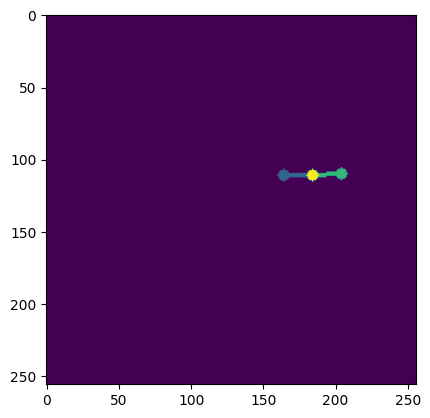

In [22]:
plt.imshow(final_mask[:,vox[1],:].transpose()) # Adjusted the view to look like slicer

In [65]:
masked_img = nb.Nifti1Image(final_mask, img.affine, img.header)
nb.save(masked_img, 'masked_multiple.nii.gz')

In [24]:
colortable_dict

{'scalar': [1, 2, 3], 'channel': ['RHc1-2', 'RHc2-3', 'RHc1-2_RHc2-3']}

In [70]:
# How to get specific labels
# Test for RHc1-2
colortable_df = pd.DataFrame(colortable_out)
colortable_df

,scalar,channel
0,1,RHc1-2
1,2,RHc2-3
2,3,RHc1-2_RHc2-3
3,4,RHc3-4
4,5,RHc2-3_RHc3-4
5,6,RHc4-5
6,7,RHc3-4_RHc4-5


In [74]:
scalars_chn = colortable_df["scalar"][colortable_df["channel"].str.contains("RHc1-2", case=False, regex=True)].to_list()
scalars_chn

[1, 3]

In [75]:
mask_chn = np.zeros(final_mask.shape).astype(bool)
for scalar in scalars_chn:
    mask_chn += final_mask == scalar

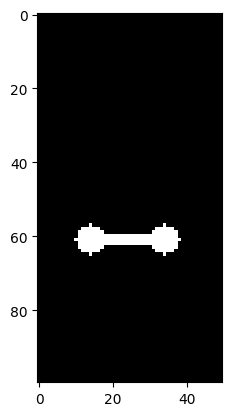

In [76]:
plt.imshow(mask_chn[150:200,vox[1],50:150].transpose(), cmap='gray') # Adjusted the view to look like slicer

# Mapping to surface

In [2]:
!kapp exec docker://khanlab/autotop_deps:v0.4.3 wb_command -volume-to-surface-mapping \
/scratch/mcesped/code/sEEGPrep/Results/mask_R.nii.gz \
/scratch/mcesped/Results/hippunfold/old_run/hippunfold/sub-P060/surf/sub-P060_hemi-R_space-T1w_den-0p5mm_label-hipp_inner.surf.gii \
/scratch/mcesped/code/HippiEEGAtlas/code/DSP/mapping.shape.gii -enclosing